# Import Libraries

# Iteration - 2

## 1. Target
*   Increase Accuarcy

## 2. Result

* Params - 7758
* Best Test accuracy - 99.35 at Epoch - 13
* Best Train accuracy - 99.44 at Epoch - 14


## 3. Analysis

* Able to increase accuracy upto 99.3%
* After adding Batch Normalization, Model was overfitting
* Added Dropout(Regularization) to counter overfitting
* Modified model to add more convolution layers and remove second maxpooling layer
* Model not overfitting - but observed test accuracy oscillations

### TODO - 
Need to counter test accuracy oscillations
Need to reach desired accuracy






In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


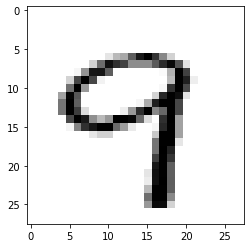

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

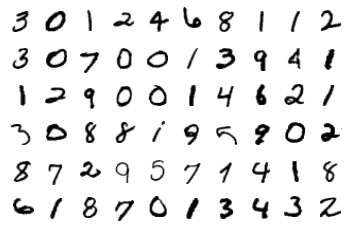

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        # self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Train set: Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Train set: Loss=0.05413362383842468 Batch_id=468 Accuracy=88.82: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1775, Accuracy: 9449/10000 (94.49%)

EPOCH: 1


Train set: Loss=0.03874767944216728 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9826/10000 (98.26%)

EPOCH: 2


Train set: Loss=0.05561518669128418 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9888/10000 (98.88%)

EPOCH: 3


Train set: Loss=0.06282996386289597 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:12<00:00, 37.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Train set: Loss=0.03964132443070412 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 37.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Train set: Loss=0.06277569383382797 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 37.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Train set: Loss=0.005394766107201576 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Train set: Loss=0.0071539548225700855 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 37.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Train set: Loss=0.01050566229969263 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Train set: Loss=0.04024824872612953 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:12<00:00, 37.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Train set: Loss=0.09007690101861954 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 37.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Train set: Loss=0.050795916467905045 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:12<00:00, 37.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Train set: Loss=0.04141544923186302 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:12<00:00, 37.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Train set: Loss=0.003998542670160532 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:12<00:00, 37.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Train set: Loss=0.0075525990687310696 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]



Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)



Text(0.5, 1.0, 'Test Accuracy')

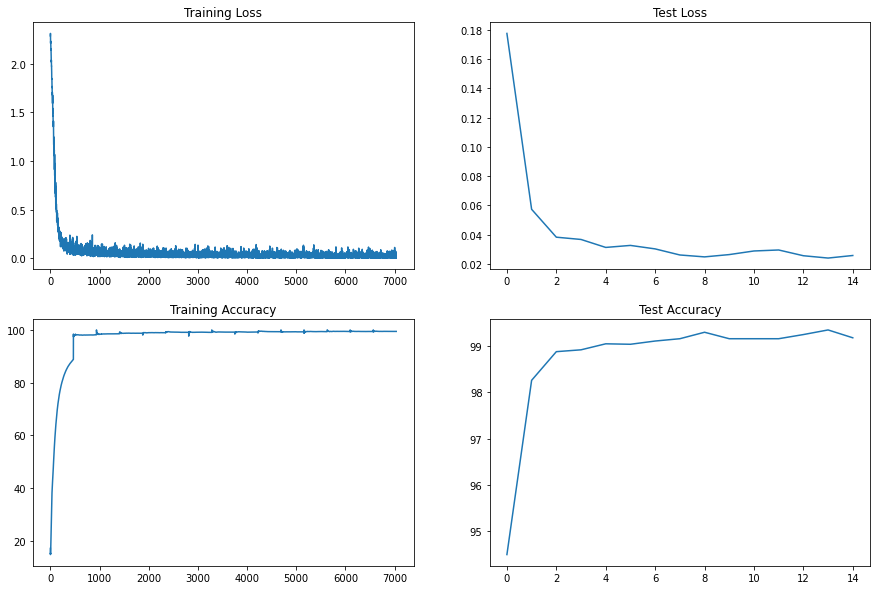

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")